In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/uware/rosbags/static/translation/21h7_s_z_2-4-6-8-10_1080_20.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.540783
1,0.521276,2.610732
2,0.956115,2.355174
3,1.942196,2.100971
4,2.431051,2.058580
...,...,...
189,100.463689,7.809729
190,100.988707,7.813029
191,101.521784,7.940363
192,102.597778,7.475091


<AxesSubplot:xlabel='relative_time'>

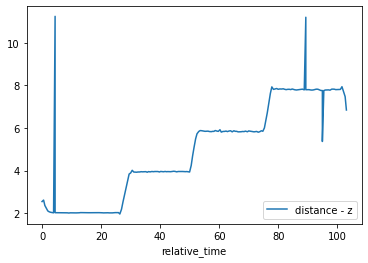

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .2)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

48

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

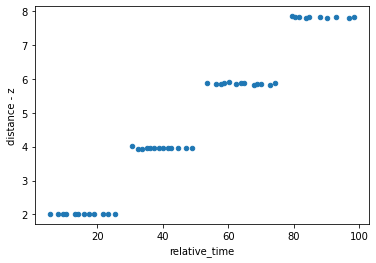

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
11,5.461821,2.018694,2
15,8.061090,2.014335,2
18,9.583225,2.011538,2
20,10.561373,2.012050,2
25,13.059792,2.021457,2
27,14.006046,2.021233,2
31,15.868028,2.015946,2
34,17.442353,2.016001,2
37,18.931322,2.020382,2
43,21.825198,2.014763,2


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
11,5.461821,2.018694,2,-0.018694
15,8.061090,2.014335,2,-0.014335
57,30.522225,4.010537,4,-0.010537
60,32.495653,3.931545,4,0.068455
101,53.523726,5.878414,6,0.121586
105,56.183814,5.851881,6,0.148119
147,79.414471,7.855208,8,0.144792
149,80.495559,7.835328,8,0.164672


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,12.0,-0.016464,0.004231,-0.021742,-0.020594,-0.015974,-0.013763,-0.009433
4,13.0,0.043658,0.018215,-0.010537,0.043495,0.046058,0.050705,0.068455
6,13.0,0.137010,0.022384,0.081676,0.130399,0.138251,0.148119,0.165244
8,10.0,0.174196,0.018341,0.144792,0.165342,0.173398,0.178683,0.208672


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

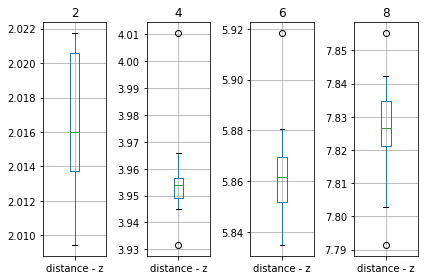

In [16]:
box_plotter(target)

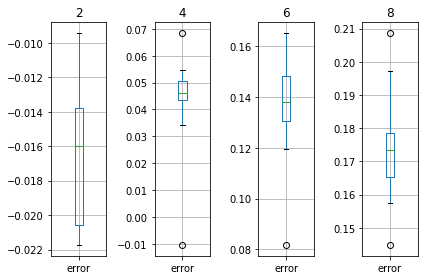

In [17]:
box_plotter('error')